# Análise do Portfolio de Fundos

### Inicializações

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime,timedelta
import math
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_style("whitegrid")


In [2]:
#Get the Exchange Rates
exchange_rates_csv = 'exchange_rates.csv'
exchange_rates = pd.read_csv(exchange_rates_csv ,sep=';',parse_dates=[0])
exchange_rates['Date'] = exchange_rates['Date'].apply(lambda x: x.date())
exchange_rates = exchange_rates.set_index('Date')
exchange_rates.head()

,USD2EUR
Date,
2023-12-26,0.90563
2023-12-25,0.90752
2023-12-24,0.90706
2023-12-23,0.90692
2023-12-22,0.90692


In [3]:
#Get the Portofolio
portfolio_csv = 'portofolio.csv'
df_portofolio = pd.read_csv(portfolio_csv ,sep=';').set_index('Code')
code2name_dict = {x[0]:x[1] for x in df_portofolio.itertuples()}
df_portofolio.sort_values(by="Nome", axis=0)

,Nome,Moeda,Quantidade
Code,,,
LU1883314244,Amundi Europ Value A C,EUR,24.0560
IE00B23S7K36,BNY Mellon Brazil Equity,EUR,3835.9600
LU1495982271,Black Strat Asia Pacif Abs E2,EUR,111.7300
LU0108459040,Candriam Biotech C Cap USD,USD,12.6500
LU0140363697,F Technology N,EUR,315.3770
IE00BD4GTQ32,FTGF ClearBridge Infra Val,EUR,303.2290
LU0286668966,Fidelity Asian High Yield EUR,EUR,713.7000
LU0197230542,Fidelity India Focus A,EUR,76.3100
LU0333810850,GS India Equity,EUR,114.1290


In [4]:
#Get the historical quotes 

xls = 'historico_cotacoes.xlsx'
dict_df = pd.read_excel(xls,sheet_name=None)

# Parse the date and set it as index
for key in dict_df.keys():
    dict_df[key]['Date'] = dict_df[key].apply(lambda x: pd.to_datetime(x['Date']).date(), axis=1)
    dict_df[key].set_index('Date',drop=True, inplace=True)

# Create the DataFrame from the Dictionary of Dataframes, removing rows with null values
df_all = pd.concat([dict_df[f_name][['Close']].rename(columns={'Close':f_name}) for f_name in dict_df.keys()],axis=1).sort_index(ascending=False)
df_all.head()

,IE00BLP5S460,LU0197230542,LU0122613903,LU1883314244,LU0286668966,LU1244139660,LU1176912761,LU0140363697,LU0159053015,LU0213962813,...,IE00BD4GTQ32,LU0552900242,LU1495982271,LU0319577374,IE00B23S7K36,FR0000989915,LU0108459040,LU1897414303,LU0173776047,LU1059379971
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-26,NaN,79.90,11.53,NaN,15.13,NaN,NaN,29.85,NaN,NaN,...,14.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-22,1.49,80.19,11.56,153.12,15.16,25.22,116.55,29.76,68.42,42.29,...,14.66,25.60,110.11,104.04,NaN,NaN,810.50,21.74,21.83,40.64
2023-12-21,1.49,79.56,11.64,152.76,15.19,25.09,116.77,29.82,68.13,42.99,...,14.63,25.40,110.10,103.84,1.46,1613.99,790.21,21.17,21.79,40.39
2023-12-20,1.50,79.66,11.58,153.26,15.23,25.22,116.76,29.55,68.75,42.77,...,14.63,25.51,109.64,103.99,1.45,1626.83,779.30,21.38,21.77,40.56
2023-12-19,1.49,80.87,11.62,152.96,15.19,25.28,117.14,29.99,68.90,42.83,...,14.75,25.42,109.57,103.79,1.47,1611.09,799.38,21.58,21.59,40.35


In [5]:
#Create a DataFrame starting from the furthest Date where all Funds have a valid amount, and replace a NaN with the last value known
df = df_all.loc[:df_all.index.min()].bfill().dropna()

#Create a DataFrame with the daily growth
df_grow = df.apply(lambda x: x/x.shift(-1), axis=0)
df

,IE00BLP5S460,LU0197230542,LU0122613903,LU1883314244,LU0286668966,LU1244139660,LU1176912761,LU0140363697,LU0159053015,LU0213962813,...,IE00BD4GTQ32,LU0552900242,LU1495982271,LU0319577374,IE00B23S7K36,FR0000989915,LU0108459040,LU1897414303,LU0173776047,LU1059379971
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-26,1.49,79.90,11.53,153.12,15.13,25.22,116.55,29.85,68.42,42.29,...,14.71,25.60,110.11,104.04,1.46,1613.99,810.50,21.74,21.83,40.64
2023-12-22,1.49,80.19,11.56,153.12,15.16,25.22,116.55,29.76,68.42,42.29,...,14.66,25.60,110.11,104.04,1.46,1613.99,810.50,21.74,21.83,40.64
2023-12-21,1.49,79.56,11.64,152.76,15.19,25.09,116.77,29.82,68.13,42.99,...,14.63,25.40,110.10,103.84,1.46,1613.99,790.21,21.17,21.79,40.39
2023-12-20,1.50,79.66,11.58,153.26,15.23,25.22,116.76,29.55,68.75,42.77,...,14.63,25.51,109.64,103.99,1.45,1626.83,779.30,21.38,21.77,40.56
2023-12-19,1.49,80.87,11.62,152.96,15.19,25.28,117.14,29.99,68.90,42.83,...,14.75,25.42,109.57,103.79,1.47,1611.09,799.38,21.58,21.59,40.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,1.38,70.89,8.51,133.46,15.78,15.39,116.58,19.97,43.25,40.30,...,14.53,24.02,106.56,94.44,1.27,1394.01,736.06,17.98,20.65,32.93
2022-12-26,1.38,70.81,8.60,133.28,15.84,15.50,116.58,20.34,43.46,40.31,...,14.55,23.84,106.70,94.41,1.27,1397.07,736.06,17.98,20.82,32.98
2022-12-23,1.38,69.82,8.60,133.28,15.85,15.50,116.58,20.34,43.46,40.31,...,14.55,23.84,106.70,94.41,1.27,1397.07,736.06,17.98,20.82,32.98


In [6]:
# Calculate the Portofolio Std and Growth
df_portofolio['STD'] = df_grow.std(axis=0)
df_portofolio['Growth'] = df.apply(lambda x: x[0]/x[-1]-1)
df_portofolio['Racio'] = df_portofolio['Growth']/df_portofolio['STD']

C:\Users\DUARTEMário\AppData\Local\Temp\ipykernel_23576\1491657990.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_portofolio['Growth'] = df.apply(lambda x: x[0]/x[-1]-1)


In [7]:
# Get the Current Total Amount in EUR

last_date = min(df.index[0],exchange_rates.index[0])
# Get the exchange rate for the last date of the historical quotes
usd2eur = exchange_rates.loc[last_date].iloc[0]
# Get the last Quotes
quotes = df_all.bfill().iloc[0]

df_portofolio['Amount EUR'] = df_portofolio['Moeda'].apply(lambda x: usd2eur if x == 'USD' else 1) * quotes * df_portofolio['Quantidade']

sum(df_portofolio['Amount EUR'])

242478.38413570262

c:\MyPrograms\miniconda3\envs\fundos\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\MyPrograms\miniconda3\envs\fundos\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


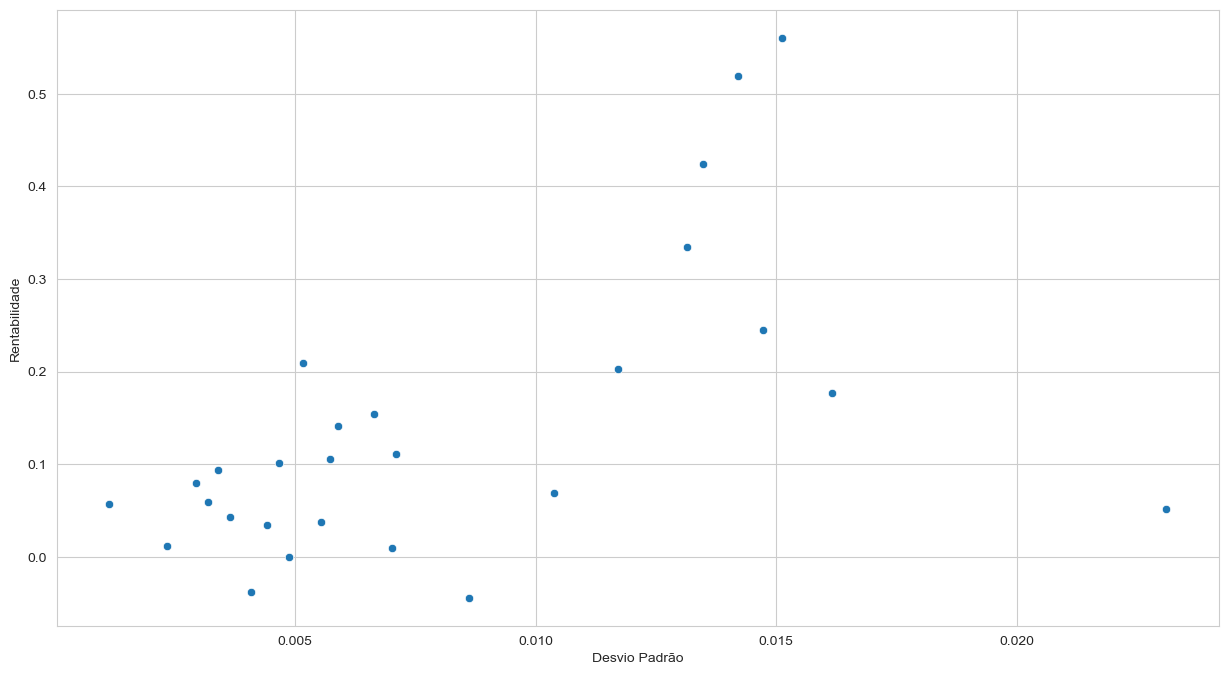

In [8]:
plt.figure(figsize=(15,8))
plt.xlabel('Desvio Padrão')
plt.ylabel('Rentabilidade')
p = sn.scatterplot(x=df_portofolio['STD'],y=df_portofolio['Growth'])

In [9]:
df_portofolio.sort_values(by=['Nome'],ascending=True)

,Nome,Moeda,Quantidade,STD,Growth,Racio,Amount EUR
Code,,,,,,,
LU1883314244,Amundi Europ Value A C,EUR,24.0560,0.005902,0.141324,23.943723,3683.454720
IE00B23S7K36,BNY Mellon Brazil Equity,EUR,3835.9600,0.016164,0.177419,10.976171,5600.501600
LU1495982271,Black Strat Asia Pacif Abs E2,EUR,111.7300,0.004412,0.034674,7.859567,12302.590300
LU0108459040,Candriam Biotech C Cap USD,USD,12.6500,0.004667,0.101133,21.669718,9285.265905
LU0140363697,F Technology N,EUR,315.3770,0.013486,0.424141,31.449319,9414.003450
IE00BD4GTQ32,FTGF ClearBridge Infra Val,EUR,303.2290,0.007027,0.009609,1.367446,4460.498590
LU0286668966,Fidelity Asian High Yield EUR,EUR,713.7000,0.008625,-0.044220,-5.127210,10798.281000
LU0197230542,Fidelity India Focus A,EUR,76.3100,0.007107,0.111111,15.635058,6097.169000
LU0333810850,GS India Equity,EUR,114.1290,0.003653,0.042500,11.635735,5235.097230


In [10]:
df_portofolio['Amount EUR'].sum()

242478.38413570262

In [11]:
df_portofolio = df_portofolio[df_portofolio.index != "LU0122613903"]

<Figure size 1500x800 with 0 Axes>

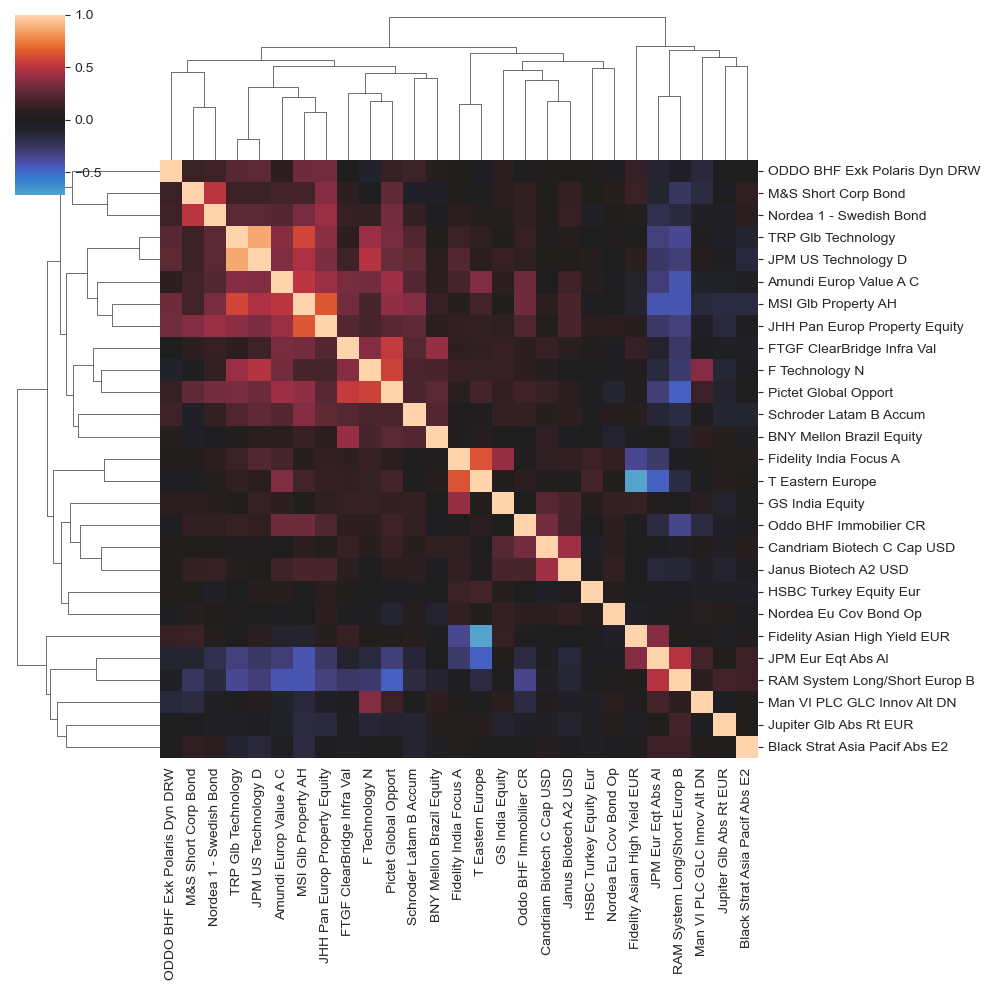

In [12]:
plt.figure(figsize=(15,8))
sn.clustermap(df_grow.rename(columns=code2name_dict).corr(),center=0)
#df_grow.corr()

In [13]:
##### Performance in the last days
df_portofolio_tmp = df_portofolio.copy()
start =71
finish = 0
print('Start Date:',df_all.index[start])
df_portofolio_tmp['Growth'] = df_all.bfill().ffill().apply(lambda x: x[finish]/x[start]-1)
df_portofolio_tmp['Racio'] = df_portofolio_tmp['Growth']/df_portofolio_tmp['STD']
# Save Portfoloio
# df_portofolio_tmp.sort_values(by=['Racio'],ascending=False).to_csv("portfolio_data.csv",sep=",")
# Show Portfolio
df_portofolio_tmp.sort_values(by=['Growth'],ascending=False)

Start Date: 2023-09-15


C:\Users\DUARTEMário\AppData\Local\Temp\ipykernel_23576\2557477876.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_portofolio_tmp['Growth'] = df_all.bfill().ffill().apply(lambda x: x[finish]/x[start]-1)


,Nome,Moeda,Quantidade,STD,Growth,Racio,Amount EUR
Code,,,,,,,
LU1897414303,Janus Biotech A2 USD,USD,318.9910,0.005174,0.209121,40.418412,6280.421192
LU1059379971,JHH Pan Europ Property Equity,USD,137.1230,0.014735,0.171519,11.640578,5046.785029
LU1244139660,TRP Glb Technology,USD,883.1200,0.015125,0.142728,9.436835,20170.450732
LU0173776047,Nordea 1 - Swedish Bond,EUR,532.9680,0.005544,0.139948,25.245145,11634.691440
LU0108459040,Candriam Biotech C Cap USD,USD,12.6500,0.004667,0.101133,21.669718,9285.265905
LU0140363697,F Technology N,EUR,315.3770,0.013486,0.095815,7.104511,9414.003450
LU0159053015,JPM US Technology D,EUR,156.4210,0.014213,0.084654,5.956320,10702.324820
IE00B23S7K36,BNY Mellon Brazil Equity,EUR,3835.9600,0.016164,0.073529,4.548948,5600.501600
LU0552900242,MSI Glb Property AH,EUR,216.3570,0.010384,0.071130,6.849854,5538.739200


Start Date: 2023-09-15


C:\Users\DUARTEMário\AppData\Local\Temp\ipykernel_23576\2178531849.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_all_tmp = df_all.bfill().ffill().apply(lambda x: x/x[start], axis=0)[fund_filter]


<Axes: xlabel='Date'>

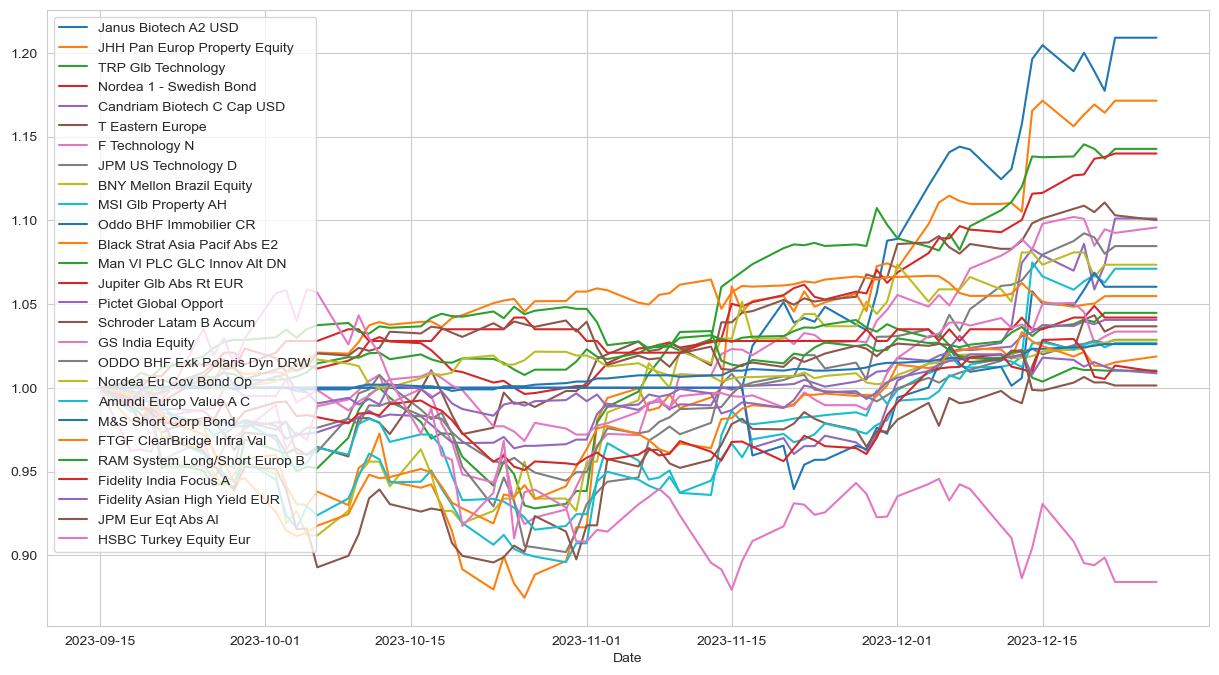

In [14]:
# Select Funds
fund_filter = df_all.columns
#fund_filter = []

print('Start Date:',df_all.index[start])
df_all_tmp = df_all.bfill().ffill().apply(lambda x: x/x[start], axis=0)[fund_filter]
df_all_tmp = df_all_tmp.sort_values(by=df_all_tmp.index[finish],axis=1,ascending=False).rename(columns=code2name_dict)
ax = df_all_tmp.iloc[finish:start+1].plot(figsize=(15,8),grid=True)
ax.legend(loc='upper left')
ax

In [15]:
##### Performance in the last days
df_portofolio_tmp = df_portofolio.copy()
start =10
finish = 0
print('Start Date:',df_all.index[start])
df_portofolio_tmp['Growth'] = df_all.bfill().ffill().apply(lambda x: x[finish]/x[start]-1)
df_portofolio_tmp['Racio'] = df_portofolio_tmp['Growth']/df_portofolio_tmp['STD']
# Save Portfoloio
# df_portofolio_tmp.sort_values(by=['Nome'],ascending=True)
df_portofolio_tmp.sort_values(by=['Racio'],ascending=False) #.to_csv("portfolio_data.csv",sep=",")


Start Date: 2023-12-11


C:\Users\DUARTEMário\AppData\Local\Temp\ipykernel_23576\2179664248.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_portofolio_tmp['Growth'] = df_all.bfill().ffill().apply(lambda x: x[finish]/x[start]-1)


,Nome,Moeda,Quantidade,STD,Growth,Racio,Amount EUR
Code,,,,,,,
LU0108459040,Candriam Biotech C Cap USD,USD,12.6500,0.004667,0.072416,15.516576,9285.265905
LU1897414303,Janus Biotech A2 USD,USD,318.9910,0.005174,0.075173,14.529261,6280.421192
LU0173776047,Nordea 1 - Swedish Bond,EUR,532.9680,0.005544,0.043000,7.756846,11634.691440
LU1670718219,M&S Short Corp Bond,EUR,932.8970,0.001146,0.008242,7.189368,10271.195970
FR0000989915,Oddo BHF Immobilier CR,EUR,8.3410,0.006652,0.047236,7.101583,13462.290590
LU0552900242,MSI Glb Property AH,EUR,216.3570,0.010384,0.057851,5.571126,5538.739200
LU0941349275,Pictet Global Opport,EUR,43.8789,0.003189,0.016104,5.049548,5177.271411
IE00BDRKSX26,Man VI PLC GLC Innov Alt DN,USD,93.9320,0.003405,0.016626,4.882393,11235.733516
LU1915690918,Nordea Eu Cov Bond Op,EUR,110.2560,0.002351,0.008894,3.782468,11881.186560


Start Date: 2023-12-11


C:\Users\DUARTEMário\AppData\Local\Temp\ipykernel_23576\3974027690.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_all_tmp = df_all.bfill().apply(lambda x: x/x[start], axis=0)


<Axes: xlabel='Date'>

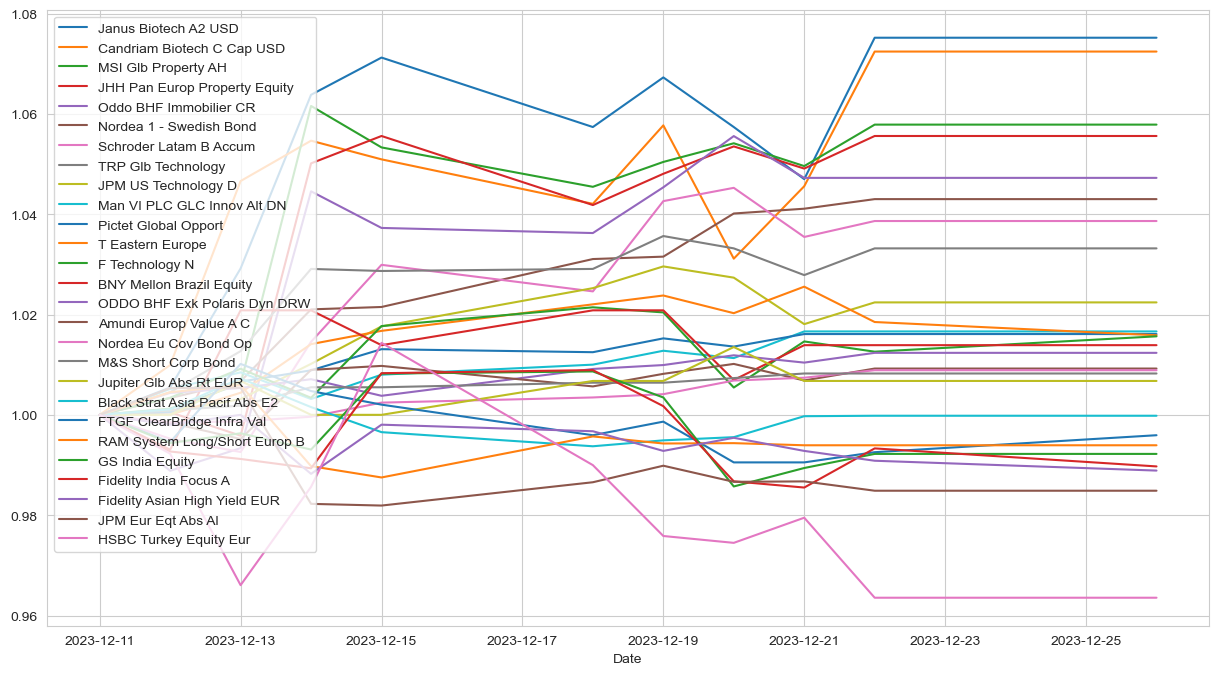

In [16]:

print('Start Date:',df_all.index[start])
df_all_tmp = df_all.bfill().apply(lambda x: x/x[start], axis=0)
df_all_tmp = df_all_tmp.sort_values(by=df_all_tmp.index[finish],axis=1,ascending=False).rename(columns=code2name_dict)
ax = df_all_tmp.iloc[finish:start+1].plot(figsize=(15,8),grid=True)
ax.legend(loc='upper left')
ax

In [17]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

if 'LU0122613903' in dict_df:
    del dict_df['LU0122613903']

# Create the DataFrame from the Dictionary of Dataframes, removing rows with null values
df_all = pd.concat([dict_df[f_name][['Close']].rename(columns={'Close':f_name}) for f_name in dict_df.keys()],axis=1).sort_index(ascending=False)
df = df_all #.dropna()

# print(df.index)

mu = mean_historical_return(df.sort_index())
S = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
df_mu = pd.DataFrame(data = {'Name':df_portofolio['Nome'],'all':list(mu)}, index=list(mu.keys()))
df_w = pd.DataFrame(data = {'Name':df_portofolio['Nome'] ,'all':list(cleaned_weights.values())}, index=list(cleaned_weights.keys()))
df_pp = pd.DataFrame(data = {'all':list(ef.portfolio_performance())}, index=list(['anual return','volatility','sharpe ratio']))
mu_coef = {'all':0.3,90:0.3,5:0.15,10:0.15,30:0.10}
mu_w = mu_coef['all']*mu
for n in mu_coef.keys()-['all']:
    mu = mean_historical_return(df[:n].sort_index())
    
    ef = EfficientFrontier(mu, S)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    if n == 60:
        mu_w += 0.30*mu
    else:
        mu_w += 0.175*mu
    df_mu[n] = list(mu)
    df_w[n] = list(cleaned_weights.values())
    df_pp[n] = list(ef.portfolio_performance())
    

ef = EfficientFrontier(mu_w, S)
weights = ef.max_sharpe()

df_w['Avg'] = list(ef.clean_weights().values())
df_w['Now'] = df_portofolio_tmp['Amount EUR']/df_portofolio_tmp['Amount EUR'].sum()
df_pp['Avg'] = list(ef.portfolio_performance())
df_mu['Avg'] = list(mu_w)
df_mu.sort_values(by="Avg",ascending=False)

c:\MyPrograms\miniconda3\envs\fundos\Lib\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = prices.pct_change().dropna(how="all")
c:\MyPrograms\miniconda3\envs\fundos\Lib\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  returns = prices.pct_change().dropna(how="all")
c:\MyPrograms\miniconda3\envs\fundos\Lib\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warnin

,Name,all,10,5,90,30,Avg
LU1897414303,Janus Biotech A2 USD,0.102470,5.537633,0.592613,3.957583,3.957583,2.488688
LU0108459040,Candriam Biotech C Cap USD,-0.006613,4.371494,1.387722,2.620743,2.620743,1.923139
LU1059379971,JHH Pan Europ Property Equity,0.234724,3.482164,0.570146,0.863455,2.967314,1.449956
FR0000989915,Oddo BHF Immobilier CR,-0.105611,3.984762,0.119967,1.632569,1.632569,1.258043
LU0552900242,MSI Glb Property AH,0.042379,3.664697,0.559762,0.310225,1.334791,1.039872
LU0173776047,Nordea 1 - Swedish Bond,0.035615,1.960495,1.006637,0.475018,1.429601,0.863241
LU0248183815,Schroder Latam B Accum,0.068395,2.303826,-0.213612,0.266290,0.848844,0.581454
LU0159053015,JPM US Technology D,0.179947,0.829336,-0.356242,0.436783,0.990217,0.386501
LU1244139660,TRP Glb Technology,-0.168062,1.199324,-0.139036,0.502951,0.917201,0.383659
LU0140363697,F Technology N,0.146013,0.404584,-0.255310,0.408330,0.861505,0.292148


In [18]:
df_mu.sort_values(by=5,ascending=False)

,Name,all,10,5,90,30,Avg
LU0108459040,Candriam Biotech C Cap USD,-0.006613,4.371494,1.387722,2.620743,2.620743,1.923139
LU0173776047,Nordea 1 - Swedish Bond,0.035615,1.960495,1.006637,0.475018,1.429601,0.863241
LU1897414303,Janus Biotech A2 USD,0.102470,5.537633,0.592613,3.957583,3.957583,2.488688
LU1059379971,JHH Pan Europ Property Equity,0.234724,3.482164,0.570146,0.863455,2.967314,1.449956
LU0552900242,MSI Glb Property AH,0.042379,3.664697,0.559762,0.310225,1.334791,1.039872
LU1495982271,Black Strat Asia Pacif Abs E2,0.046391,-0.034953,0.363049,0.150525,0.064569,0.108976
LU1915690918,Nordea Eu Cov Bond Op,0.032700,0.336313,0.348335,0.074203,0.235414,0.183806
IE00BDRKSX26,Man VI PLC GLC Innov Alt DN,0.088693,0.373915,0.269908,0.231928,0.140255,0.204409
LU0319577374,ODDO BHF Exk Polaris Dyn DRW,0.053922,0.248020,0.163655,0.187613,0.413253,0.193371
LU1670718219,M&S Short Corp Bond,0.041423,0.226536,0.121364,0.089986,0.172691,0.119278


In [19]:
df_mu.sort_values(by="Avg",ascending=False).to_csv("mu.csv")

In [20]:
df_w.sort_values(by=['Avg',5,'all',10,30,90],ascending=False)

,Name,all,10,5,90,30,Avg,Now
LU0173776047,Nordea 1 - Swedish Bond,0.00000,0.24143,0.29558,0.16277,0.29912,0.25837,0.048056
IE00BDRKSX26,Man VI PLC GLC Innov Alt DN,0.26427,0.14796,0.15939,0.17860,0.07314,0.15389,0.046408
LU1915690918,Nordea Eu Cov Bond Op,0.04159,0.12862,0.29574,0.02571,0.12903,0.15117,0.049074
IE00BLP5S460,Jupiter Glb Abs Rt EUR,0.16381,0.09327,0.00966,0.10203,0.08122,0.08381,0.062026
LU0108459040,Candriam Biotech C Cap USD,0.00000,0.07057,0.05747,0.10701,0.06765,0.07241,0.038352
LU0552900242,MSI Glb Property AH,0.00000,0.12730,0.01914,0.00000,0.00000,0.05853,0.022877
LU1897414303,Janus Biotech A2 USD,0.01706,0.04544,0.00000,0.11694,0.07215,0.05483,0.025941
LU0705071453,RAM System Long/Short Europ B,0.00000,0.05933,0.01494,0.05039,0.06496,0.03914,0.054852
LU1495982271,Black Strat Asia Pacif Abs E2,0.07548,0.00000,0.12941,0.04503,0.00000,0.03237,0.050815
LU1176912761,JPM Eur Eqt Abs Al,0.03227,0.01935,0.00000,0.09468,0.05056,0.02758,0.052719


In [21]:
df_pp

,all,10,5,90,30,Avg
anual return,0.104315,1.768404,0.582962,0.962783,1.230894,0.680604
volatility,0.022509,0.028828,0.023091,0.034682,0.031305,0.026967
sharpe ratio,3.745871,60.648920,24.380056,27.183793,38.680156,24.496778
